<a href="https://colab.research.google.com/github/rpdahxn/CV_PaperReview/blob/main/02GerativeAdversarialNets/GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset 

import pandas, numpy, random
import matplotlib.pyplot as plt

In [10]:
class MnistDataset(Dataset):

  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header = None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

    return label, image_values, target

  def plot_images(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title('label = ' + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation = 'none', cmap = 'Blues')
    pass

  pass

In [11]:
mnist_dataset = MnistDataset('/content/mount/MyDrive/Colab Notebooks/mnist_data/mnist_train.csv')

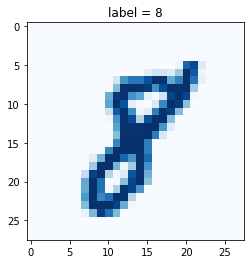

In [12]:
mnist_dataset.plot_images(17)

In [13]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []
    self.loss = 0

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    self.loss = self.loss_function(outputs, targets)

    self.counter += 1;
    # if (self.counter % 10 == 0):
    #   self.progress.append(self.loss.item())
    # if (self.counter % 10000 == 0):
    #   print("counter = ", self.counter)
    # pass

    # self.optimiser.zero_grad()
    # loss.backward()
    # self.optimiser.step()

    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

  pass

In [37]:
# 판별기 테스트
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  real_loss = D.loss

  D.train(generate_random_image(784), torch.FloatTensor([0.0]))
  fake_loss = D.loss
  
  loss = (real_loss + fake_loss) / 2
  if (D.counter % 10 == 0):
      D.progress.append(loss.item())
  if (D.counter % 10000 == 0):
      print("counter = ", D.counter)

  D.optimiser.zero_grad()
  loss.backward()
  D.optimiser.step()

  pass

counter =  10000
counter =  10000
counter =  20000
counter =  20000
counter =  30000
counter =  30000
counter =  40000
counter =  40000
counter =  50000
counter =  50000
counter =  60000
counter =  60000
counter =  70000
counter =  70000
counter =  80000
counter =  80000
counter =  90000
counter =  90000
counter =  100000
counter =  100000
counter =  110000
counter =  110000
counter =  120000
counter =  120000
CPU times: user 3min 13s, sys: 6.54 s, total: 3min 19s
Wall time: 3min 21s


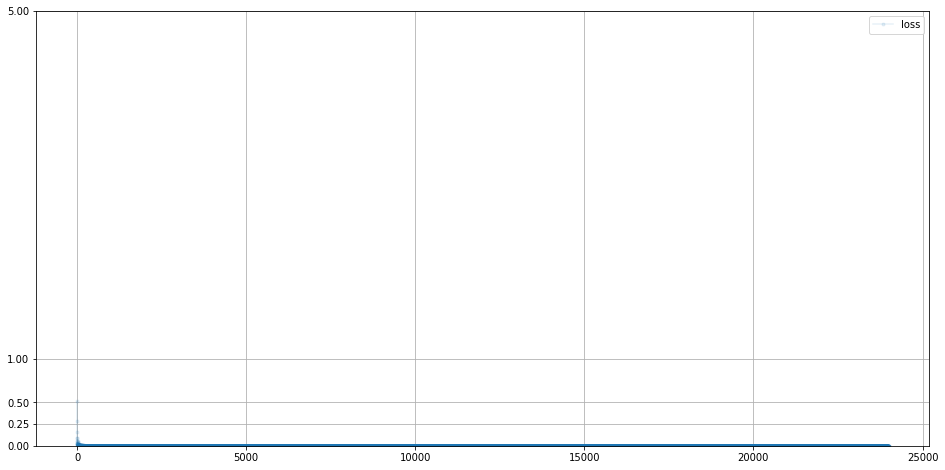

In [38]:
D.plot_progress()

In [39]:
# 가짜와 진짜를 판별할 수 있는지 판별기 직접 구동

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image(784)).item())
  pass

1.0
1.0
1.0
1.0
2.931504691772169e-11
2.682476116233623e-11
3.188163275047451e-11
2.621406217095945e-11


In [40]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  
  def forward(self, inputs):
    return self.model(inputs)


  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

  pass

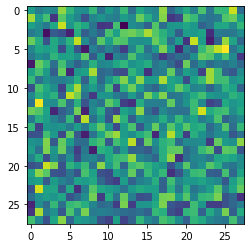

In [42]:
# 생성기의 출력이 올바른 타입과 형태를 지니고 있는지 확인

G = Generator()

output = G.forward(generate_random_seed(100))

img = output.detach().numpy().reshape(28, 28)

plt.imshow(img, interpolation = 'none')

**GAN 훈련**

In [43]:
%%time

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
  print("epoch = ", epoch + 1)


  for label, image_data_tensor, target_tensor in mnist_dataset:
    
    # Discriminator, real data train
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    real_loss = D.loss
    # Discriminator, fake data train
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))  # G의 기울기는 계산되지 않도록 detach()
    fake_loss = D.loss

    loss = (real_loss + fake_loss) / 2
    if (D.counter % 10 == 0):
      D.progress.append(loss.item())
    if (D.counter % 10000 == 0):
      print("counter = ", D.counter)

    D.optimiser.zero_grad()
    loss.backward()
    D.optimiser.step()

    # Generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass


  pass

epoch =  1
counter =  10000
counter =  10000
counter =  20000
counter =  20000
counter =  30000
counter =  30000
counter =  40000
counter =  40000
counter =  50000
counter =  50000
counter =  60000
counter =  60000
counter =  70000
counter =  70000
counter =  80000
counter =  80000
counter =  90000
counter =  90000
counter =  100000
counter =  100000
counter =  110000
counter =  110000
counter =  120000
counter =  120000
epoch =  2
counter =  130000
counter =  130000
counter =  140000
counter =  140000
counter =  150000
counter =  150000
counter =  160000
counter =  160000
counter =  170000
counter =  170000
counter =  180000
counter =  180000
counter =  190000
counter =  190000
counter =  200000
counter =  200000
counter =  210000
counter =  210000
counter =  220000
counter =  220000
counter =  230000
counter =  230000
counter =  240000
counter =  240000
epoch =  3
counter =  250000
counter =  250000
counter =  260000
counter =  260000
counter =  270000
counter =  270000
counter =  28

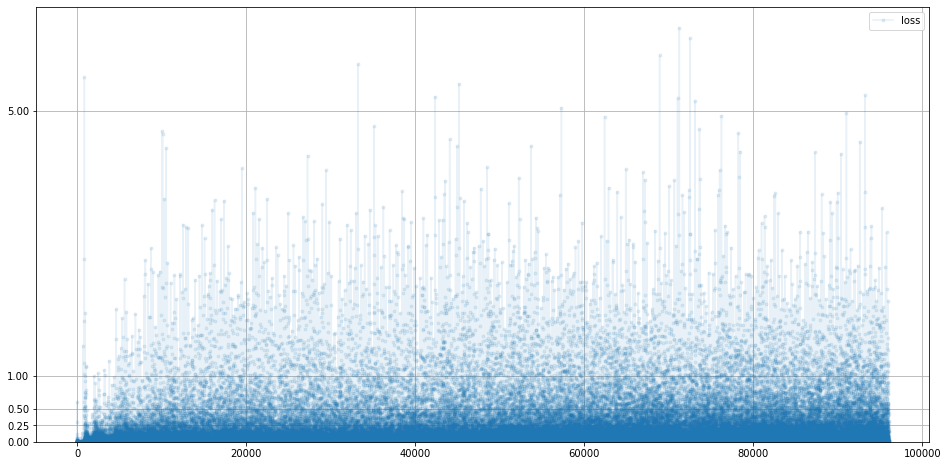

In [44]:
D.plot_progress()

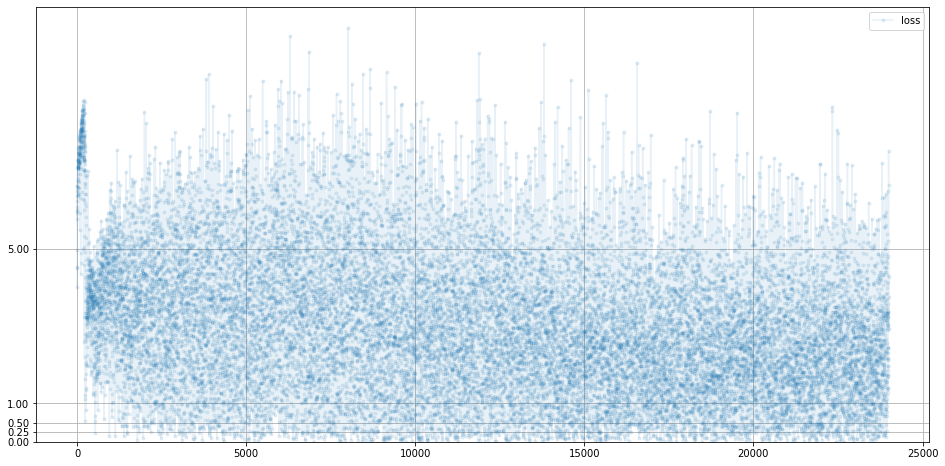

In [45]:
G.plot_progress()

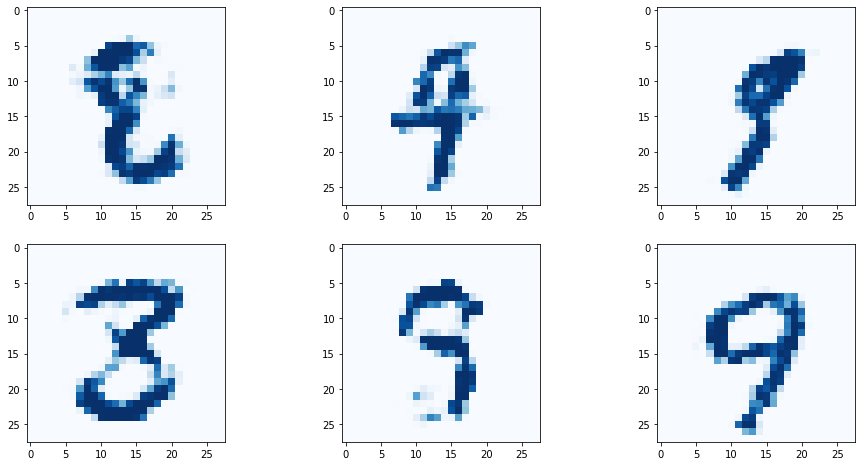

In [46]:
# 훈련된 생성기로부터 몇 개의 출력을 플롯해 본다.

f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation = 'none', cmap = 'Blues')
    pass
  pass

In [47]:
%%time

D = Discriminator()
G = Generator()

epochs = 10

for epoch in range(epochs):
  print("epoch = ", epoch + 1)


  for label, image_data_tensor, target_tensor in mnist_dataset:
    
    # Discriminator, real data train
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    real_loss = D.loss
    # Discriminator, fake data train
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))  # G의 기울기는 계산되지 않도록 detach()
    fake_loss = D.loss

    loss = (real_loss + fake_loss) / 2
    if (D.counter % 10 == 0):
      D.progress.append(loss.item())
    if (D.counter % 10000 == 0):
      print("counter = ", D.counter)

    D.optimiser.zero_grad()
    loss.backward()
    D.optimiser.step()

    # Generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass


  pass

epoch =  1
counter =  10000
counter =  10000
counter =  20000
counter =  20000
counter =  30000
counter =  30000
counter =  40000
counter =  40000
counter =  50000
counter =  50000
counter =  60000
counter =  60000
counter =  70000
counter =  70000
counter =  80000
counter =  80000
counter =  90000
counter =  90000
counter =  100000
counter =  100000
counter =  110000
counter =  110000
counter =  120000
counter =  120000
epoch =  2
counter =  130000
counter =  130000
counter =  140000
counter =  140000
counter =  150000
counter =  150000
counter =  160000
counter =  160000
counter =  170000
counter =  170000
counter =  180000
counter =  180000
counter =  190000
counter =  190000
counter =  200000
counter =  200000
counter =  210000
counter =  210000
counter =  220000
counter =  220000
counter =  230000
counter =  230000
counter =  240000
counter =  240000
epoch =  3
counter =  250000
counter =  250000
counter =  260000
counter =  260000
counter =  270000
counter =  270000
counter =  28

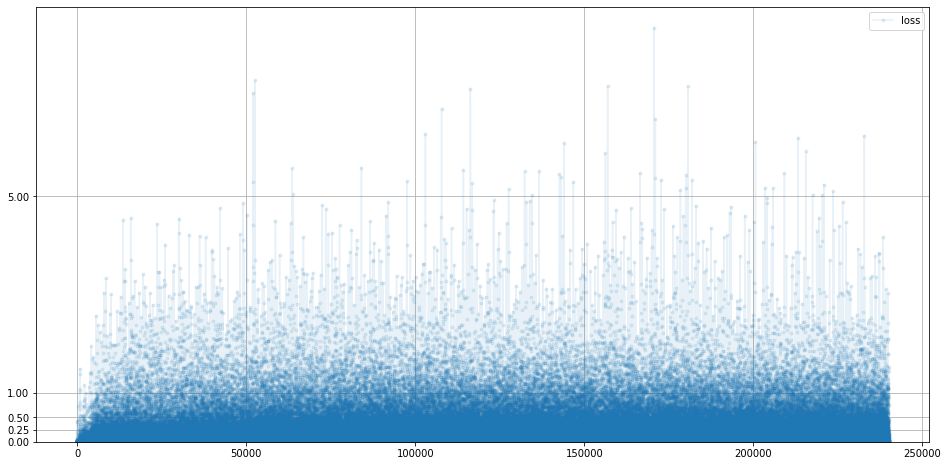

In [49]:
D.plot_progress()

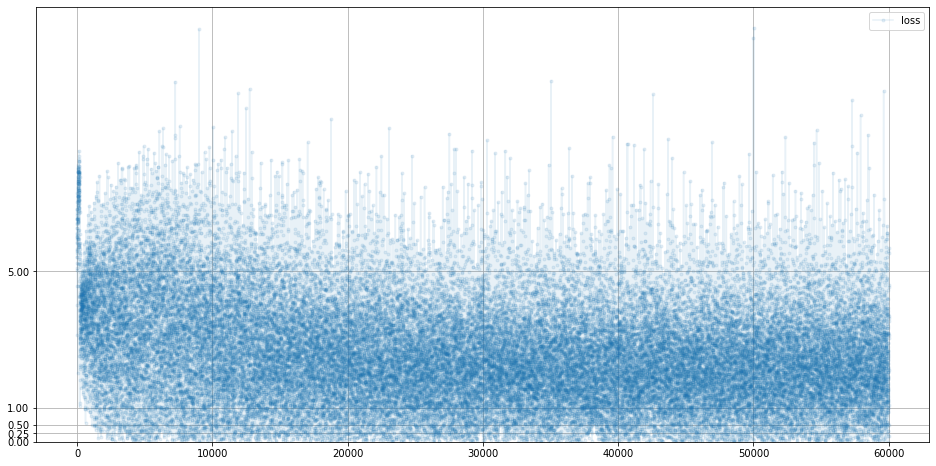

In [50]:
G.plot_progress()

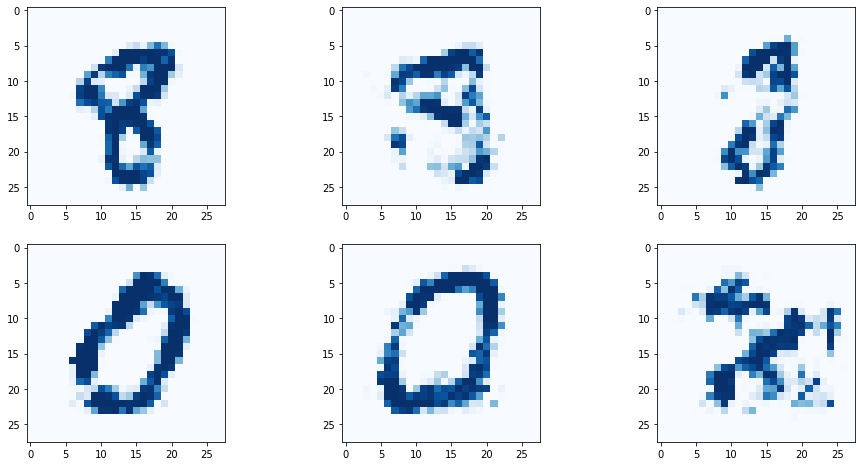

In [48]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation = 'none', cmap = 'Blues')
    pass
  pass